# Vehicle detection

In [84]:
from sklearn import svm,  grid_search
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import cv2
from skimage.feature import hog
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

## 1. Process the data

In [9]:
## read in the data
with_car_files = glob.glob('train_data/vehicles/GTI_Far/*.png') + glob.glob('train_data/vehicles/GTI_Left/*.png') + \
                glob.glob('train_data/vehicles/GTI_MiddleClose/*.png') + glob.glob('train_data/vehicles/GTI_Right/*.png') \
                + glob.glob('train_data/vehicles/KITTI_extracted/*.png')
non_car_files = glob.glob('train_data/non-vehicles/Extras/*.png') + glob.glob('train_data/non-vehicles/GTI/*.png')

with_car_pics = []
non_car_pics = []
for file in with_car_files:
    image = mpimg.imread(file)
    with_car_pics.append(image)
for file in non_car_files:
    image = mpimg.imread(file)
    non_car_pics.append(image)
    
print('Together %d images with car and %d images without car' %(len(with_car_pics), len(non_car_pics)))

Together 8792 images with car and 8968 images without car


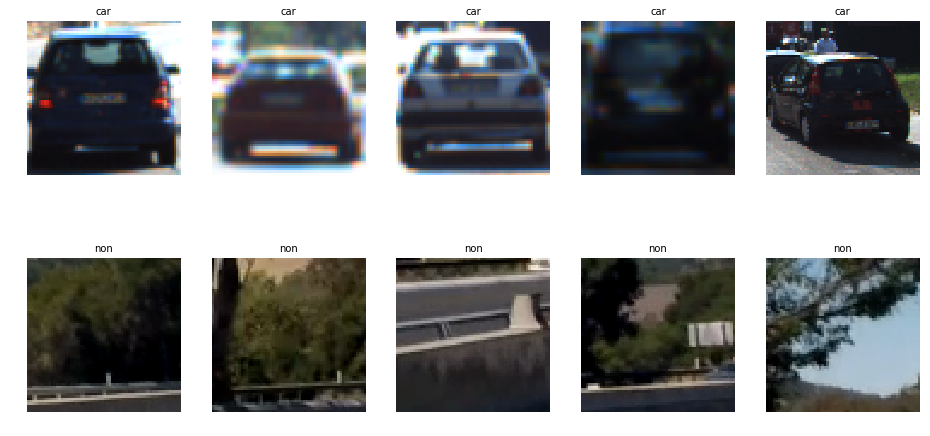

In [19]:
## show some of the pictures
plt.figure(figsize=(16,8))
for i in range(5):
    plt.subplot(2,5,i+1).axis('off')
    plt.subplot(2,5,i+1).set_title('car', fontsize=10)
    plt.imshow(with_car_pics[4000 + 100 * i])
    plt.subplot(2,5,i+6).axis('off')
    plt.subplot(2,5,i+6).set_title('non', fontsize=10)
    plt.imshow(non_car_pics[4000 + 100 * i])

In [25]:
## show the data size
print('data size is:', non_car_pics[0].shape)

data size is: (64, 64, 3)


In [26]:
## define a function to find hog features of the images
## set vis as true to show the result.

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,
                     feature_vec=True):
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

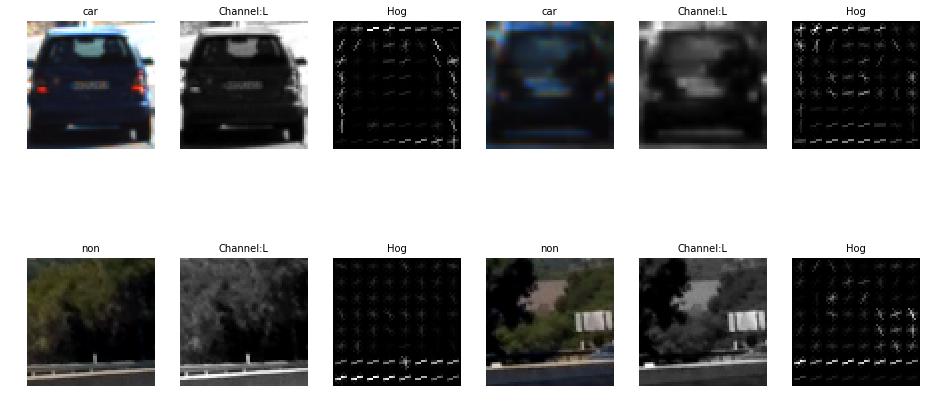

In [63]:
## visualize the result of Hog on the image in L channels
cell_per_block_set = 2
channel = 1

plt.figure(figsize=(16,8))
for i in (0, 3):
    channel_name = ('H', 'L', 'S')
    
    plt.subplot(2,6,i+1).axis('off')
    plt.subplot(2,6,i+1).set_title('car', fontsize=10)
    plt.imshow(with_car_pics[4000 + 100 * i])
    
    plt.subplot(2,6,i+2).axis('off')
    plt.subplot(2,6,i+2).set_title('Channel:' + channel_name[channel], fontsize=10)  
    img_channel = cv2.cvtColor(with_car_pics[4000 + 100 * i], cv2.COLOR_RGB2HLS)[:,:,channel]
    plt.imshow(img_channel, cmap = 'gray')
    
    plt.subplot(2,6,i+3).axis('off')
    plt.subplot(2,6,i+3).set_title('Hog', fontsize=10)
    _, ret = get_hog_features(img_channel, orient = 9, pix_per_cell= 8, cell_per_block= cell_per_block_set, vis = True)
    plt.imshow(ret, cmap = 'gray')
    
    plt.subplot(2,6,i+7).axis('off')
    plt.subplot(2,6,i+7).set_title('non', fontsize=10)
    plt.imshow(non_car_pics[4000 + 100 * i])
    
    
    plt.subplot(2,6,i+8).axis('off')
    plt.subplot(2,6,i+8).set_title('Channel:' + channel_name[channel], fontsize=10)  
    img_channel = cv2.cvtColor(non_car_pics[4000 + 100 * i], cv2.COLOR_RGB2HLS)[:,:,channel]
    plt.imshow(img_channel, cmap = 'gray')    
    
    plt.subplot(2,6,i+9).axis('off')
    plt.subplot(2,6,i+9).set_title('Hog', fontsize=10)
    img_channel = cv2.cvtColor(non_car_pics[4000 + 100 * i], cv2.COLOR_RGB2HLS)[:,:,channel]
    _, ret = get_hog_features(img_channel, orient = 9, pix_per_cell= 8, cell_per_block= cell_per_block_set, vis = True)
    plt.imshow(ret, cmap = 'gray')

In [80]:
## combine the features in color space

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def his_extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            string = 'cv2.COLOR_RGB2' + cspace
            image = cv2.cvtColor(image, eval(string)) 
        # Apply bin_spatial() to get spatial color features
        spatial = bin_spatial(image, size=spatial_size)
        # Apply color_hist() to get color histogram features
        histogram = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial, histogram)))
    # Return list of feature vectors
    return features

In [70]:
## combine the features in hog

def hog_extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            string = 'cv2.COLOR_RGB2' + cspace
            feature_image = cv2.cvtColor(image, eval(string)) 
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [75]:
## generate the labels for datas
Y = []
for i in with_car_pics:
    Y.append(1)
for i in non_car_pics:
    Y.append(0)
print('Finish!')

Finish!


In [71]:
## extra the hog features for training and set the corresponding labels
color_space = 'HLS' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
hogchannel = 'ALL' # can be 0, 1, 2 or 'ALL'
orientation = 9
pixpercell = 8
cellperblock = 2

hog_X_with = hog_extract_features(with_car_pics, cspace = color_space, orient = orientation, pix_per_cell=pixpercell, 
                                  cell_per_block = cellperblock, hog_channel = hogchannel)
hog_X_non = hog_extract_features(non_car_pics, cspace = color_space, orient = orientation, pix_per_cell=pixpercell, 
                                  cell_per_block = cellperblock, hog_channel = hogchannel)

print('Finish!')

Finish!


In [81]:
## extra the histogram color features for training and set the corresponding labels
colorspace='RGB'
spatialsize=(32, 32)
histbins=32
histrange=(0, 256)

his_X_with = his_extract_features(with_car_pics, cspace=colorspace, spatial_size=spatialsize, 
                                  hist_bins=histbins, hist_range=histrange)
his_X_non = his_extract_features(non_car_pics, cspace=colorspace, spatial_size=spatialsize, 
                                  hist_bins=histbins, hist_range=histrange)
print('Finish!')

Finish!


In [87]:
## split the data into validation(20%) and training set,also shuffle the data. 
X_hog = hog_X_non + hog_X_with
X_his = his_X_with + his_X_non
rand_state = random.randint(0,99)

X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(
    X_hog, Y, test_size=0.2, random_state=rand_state)

X_train_his, X_test_his, y_train_his, y_test_his = train_test_split(
    X_his, Y, test_size=0.2, random_state=rand_state)

print('Finish!')

Finish!


In [88]:
# Fit a per-column scaler
X_scaler_hog = StandardScaler().fit(X_train_hog)
X_scaler_his = StandardScaler().fit(X_train_his)
# Apply the scaler
scaled_train_X_hog = X_scaler_hog.transform(X_train_hog)
scaled_train_X_his = X_scaler_his.transform(X_train_his)

print('Finish!')

Finish!


In [ ]:
## visualize the data

## 2. Train the svm classifier

### Train a classifier with hog features

In [ ]:
print('start tuning the parameters......')
parameters = {'degree':[16, 24, 32], 'coef0': [-8, 0, 8], 'C': [8, 16, 24]}
tune_step = {'degree':8, 'coef0': 8, 'C': 8}
svr = svm.SVC(kernel='poly')
old_score = 0.
j = 1

while True:
    print('epoch', j, ', start at:', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    j = j + 1
    clf = grid_search.GridSearchCV(svr, parameters, cv=4, n_jobs = 2)
    clf.fit(X, Y)
    new_score = clf.best_score_
    print('Parameters: ', clf.best_params_)
    print('Score: ', new_score)
    if new_score-old_score >= 0.01:
        old_score = new_score
        for i in parameters:
            if i == 'degree' and tune_step[i] == 1:
                if len(parameters[i]) > 1:
                    parameters[i] = [clf.best_params_[i]]
                continue
            elif i == 'C':
                if clf.best_params_[i] == parameters[i][1]:
                    tune_step[i] = tune_step[i]/2
                    parameters[i] = [clf.best_params_[i]-tune_step[i], clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
                elif clf.best_params_[i] == parameters[i][0]:
                    parameters[i] = [clf.best_params_[i]/2, clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
                else:
                    parameters[i] = [clf.best_params_[i]-tune_step[i], clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
            elif clf.best_params_[i] == parameters[i][1]:
                tune_step[i] = tune_step[i]/2
                parameters[i] = [clf.best_params_[i]-tune_step[i], clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
            else:
                parameters[i] = [clf.best_params_[i]-tune_step[i], clf.best_params_[i], clf.best_params_[i]+tune_step[i]]
    else:
        break


print('tuning finished!')

## 3. Implement sliding windows to find a car

In [1]:
## define a function to draw the boxes on picture for visualizing the sliding windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [2]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list